# Imports

In [ ]:
!pip install emoji
!pip install wordcloud
!pip install nltk

     |████████████████████████████████| 170 kB 13.9 MB/s 
  Created wheel for emoji: filename=emoji-1.6.1-py3-none-any.whl size=169314 sha256=d8d8d5da2b27b9adb8a4173a55c0d5574541995690fc5db6b55965b144db1e5d
  Stored in directory: /root/.cache/pip/wheels/ea/5f/d3/03d313ddb3c2a1a427bb4690f1621eea60fe6f2a30cc95940f
Successfully built emoji


In [ ]:
import re
import string
import unicodedata
import numpy as np 
import random
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import html
import string
import emoji
from sklearn.metrics import accuracy_score, f1_score, classification_report,confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
#import xgboost as xgb
from sklearn.naive_bayes import BernoulliNB
from bs4 import BeautifulSoup
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from wordcloud import WordCloud
import warnings
warnings.filterwarnings("ignore")
import nltk
nltk.download("stopwords") 
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 
from emoji.unicode_codes import UNICODE_EMOJI
from nltk.corpus import stopwords  
from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words('english')) 
lem=WordNetLemmatizer()
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
sns.set_style('darkgrid')
import inflect
from collections import Counter 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


# Loading Datasets

In [ ]:
sentiments_df = pd.read_csv("/content/Canadian_elections_2021.csv")
canadian_election_df = pd.read_csv("/content/sentiment_analysis.csv")

In [ ]:
# Creating copy of the datasets for use in future steps 
election_df = canadian_election_df.copy()
sentiments = sentiments_df.copy()

In [ ]:
canadian_election_df.head()

,text,sentiment,negative_reason
0,The Canadian election is a power grab by PM Tr...,negative,calling election early
1,I do hope Trudeau loses the Canadian election ...,negative,covid
2,"Dear Canadians, This election is a test of how...",positive,NaN
3,Canadian friends: Never forget that Trudeau ha...,negative,calling election early
4,Sorry @theJagmeetSingh I have voted #NDP all m...,positive,NaN


In [ ]:
sentiments_df.head()

,ID,text,label
0,7.680980e+17,Josh Jenkins is looking forward to TAB Breeder...,1
1,7.680980e+17,RT @MianUsmanJaved: Congratulations Pakistan o...,1
2,7.680980e+17,"RT @PEPalerts: This September, @YESmag is taki...",1
3,7.680980e+17,"RT @david_gaibis: Newly painted walls, thanks ...",1
4,7.680980e+17,RT @CedricFeschotte: Excited to announce: as o...,1


In [ ]:
print(canadian_election_df.shape)
print(sentiments_df.shape)

(1002, 3)
(550391, 3)


# Data Cleaning

In [ ]:
def clean_text(text):

    # convert 'RT @'' to '@' and Remove the word after @
    rt = re.compile('RT @')
    text = re.sub(rt, '@', str(text))
    at = re.compile('@(?=\w+)\w+')
    text = re.sub(at,'', str(text))
    
    #remove https
    text = re.sub(r"http", "", text)
    
    #remove emoji
    text = emoji.demojize(text)
    
    #Remove numerical data
    text = re.sub('[^A-Za-z]'," ",text)
    
    #remove html tags and attributes
    text = BeautifulSoup(text,'html.parser').get_text()

    #replace ASCII
    text = html.unescape(text)
    text = unicodedata.normalize('NFKD',text).encode('ascii','ignore').decode('utf-8')

    #remove URLs
    text = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', text)
    
    #lowercase
    text = text.lower()

    #remove stop words 
    text = [word for word in tokenizer.tokenize(text) if word not in stopwords.words('english')]
    
    #lemmatize words
    text = [lem.lemmatize(word, pos='v') for word in text]
    text = [lem.lemmatize(word, pos='n') for word in text]
    return text

In [ ]:
# Cleaning the sentiments dataset

sentiments_df['text'] = sentiments_df['text'].apply(clean_text)

In [ ]:
sentiments_df.head()

,ID,text,label
0,7.680980e+17,"[josh, jenkins, look, forward, tab, breeder, c...",1
1,7.680980e+17,"[congratulation, pakistan, become, testteam, w...",1
2,7.680980e+17,"[september, take, maine, mendoza, surprise, th...",1
3,7.680980e+17,"[newly, paint, wall, thank, million, custodial...",1
4,7.680980e+17,"[excite, announce, july, feschotte, lab, reloc...",1


In [ ]:
# Applying the data cleaning function on the canadian election dataset
canadian_election_df['text'] = canadian_election_df['text'].apply(clean_text)
canadian_election_df.head()

,text,sentiment,negative_reason
0,"[canadian, election, power, grab, pm, trudeau,...",negative,calling election early
1,"[hope, trudeau, lose, canadian, election, tomo...",negative,covid
2,"[dear, canadian, election, test, progressive, ...",positive,NaN
3,"[canadian, friend, never, forget, trudeau, yea...",negative,calling election early
4,"[sorry, vote, ndp, life, election, fight, free...",positive,NaN


## EDA

 Extreacting all usernames and hashtags mentioned in the election dataset tweets. As we have already cleaned the dataset in the previous step, we can use the copy of the dataset created in the previous steps

In [ ]:
# Extreacting all usernames mentioned in the election tweets dataset
username = []
def username_extract(x):
    for i in x:
        un = election_df.text.str.extractall(r'(\@\w+)')[0].value_counts()
        username.append(un)
    return username

In [ ]:
# Display usernames/mentions ("@") in tweets
username = username_extract(canadian_election_df['text'])
username

In [ ]:
# Extreacting all hashtags mentioned in the election tweets dataset
hashtags = []
def hashtag_extract(x):
    for i in x:
        ht = election_df.text.str.extractall(r'(\#\w+)')[0].value_counts()
        hashtags.append(ht)
    return hashtags

In [ ]:
# Display hashtags used in Tweets
hashtags = hashtag_extract(election_df['text'])
hashtags

[#Elxn44                    95
 #cdnpoli                   79
 #NeverVoteConservative     51
 #VotePPC                   43
 #VoteLiberal               38
                            ..
 #JagmeetSingh               1
 #USA                        1
 #Puke                       1
 #TrudeausVanityElection     1
 #canadanews                 1
 Name: 0, Length: 309, dtype: int64,
 #Elxn44                    95
 #cdnpoli                   79
 #NeverVoteConservative     51
 #VotePPC                   43
 #VoteLiberal               38
                            ..
 #JagmeetSingh               1
 #USA                        1
 #Puke                       1
 #TrudeausVanityElection     1
 #canadanews                 1
 Name: 0, Length: 309, dtype: int64,
 #Elxn44                    95
 #cdnpoli                   79
 #NeverVoteConservative     51
 #VotePPC                   43
 #VoteLiberal               38
                            ..
 #JagmeetSingh               1
 #USA                      

The classify function divides the tweets into four categories. The function uses list of words and matches the words used in the tweets relevant to a particular party.
The lists used for matching was created by going through various media sources and by considering the party slogans, their election manifesto for the year 2021,various party leader names and the hashtags and usernames extracted in the previous steps.

In [ ]:
def classify(text):
    liberal = ['stand','pm,','team''justintrudeau','liberal','trudeau','teamtrudeau','justin','forward','everyone','prime','minister','majority','never','again','liberal','liberals','economy','mandatory','votetrudeau','anita']
    conservative = ['erinotoole','secure','future','erin','otoole','conservatives','cpc','conservative','candice','bergin']
    ndp = ['ndp','fighting','better','ready','jagmeet','singh','new democratic party','jagmeetsingh','democrats','democratic','uprisingh','ready for change','change']
    ppc = ['purple','wave','maxime','bernier','maximebernier','common sense policies that put canadians first','first','canadians','common sense','first','ppcstore','sense','common']

    match = []


    #classification of political parties
    for word in text:
        if word in liberal:
              match.append('Liberals')
        elif word in conservative:
              match.append('Conservatives')
        elif word in ndp:
              match.append('NDP')
        elif word in ppc:
              match.append('PPC')

    # append most frequent party in case of multiple parties
    if len(match) > 1:
        most_frequent = max(set(match), key=match.count)
        match = []
        match.append(most_frequent)
        
    # In case of no match
    elif len(match) == 0:
        match.append('None')
    
    #return words as value
    return match[0]

In [ ]:
# applying the classify function on canadian elections dataset
canadian_election_df['party'] = list(map(classify,canadian_election_df['text']))
canadian_election_df.head()

,text,sentiment,negative_reason,party
0,"[canadian, election, power, grab, pm, trudeau,...",negative,calling election early,Liberals
1,"[hope, trudeau, lose, canadian, election, tomo...",negative,covid,Liberals
2,"[dear, canadian, election, test, progressive, ...",positive,NaN,Liberals
3,"[canadian, friend, never, forget, trudeau, yea...",negative,calling election early,Liberals
4,"[sorry, vote, ndp, life, election, fight, free...",positive,NaN,PPC


In [ ]:
# value counts of classified tweets
canadian_election_df['party'].value_counts()

None             313
Liberals         295
Conservatives    250
NDP               93
PPC               51
Name: party, dtype: int64

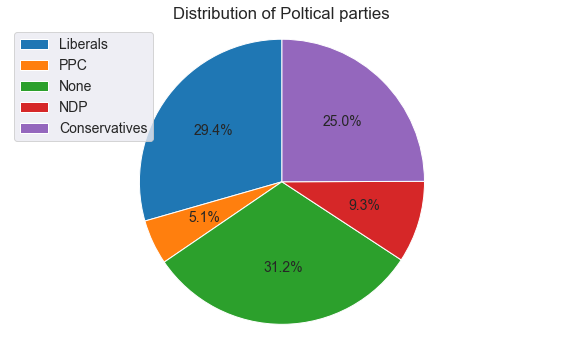

In [ ]:
parties = canadian_election_df['party'].tolist()
p_count = Counter(parties)
fig, ax = plt.subplots(figsize=[8,5])
ax.pie(p_count.values(),rotatelabels = True,labeldistance=0.5, pctdistance=0.6, startangle=90,autopct='%1.1f%%')
ax.axis('equal')  
ax.set_title('Distribution of Poltical parties')
plt.legend(labels=p_count.keys(),loc="upper left")
plt.rcParams['font.size'] = 13
fig.tight_layout()

plt.show()

The following plot shows the classification of parties based on the nature of tweets. We can observe that the most number of tweets were classified as liberal party tweets while 'people's party of Canada' has the least count of tweets. The count of tweets for conservatives is also quite high and is very close to that of the liberals. Around 31% of the tweets could not be classified

# Plot for positive and negative tweets with respect to each party.

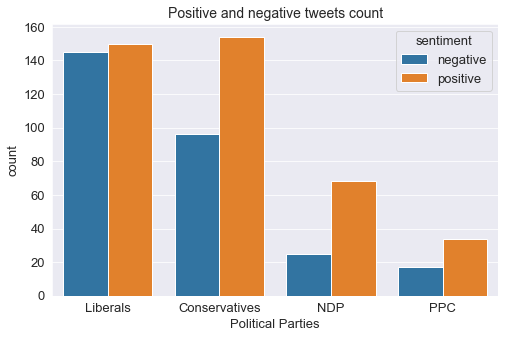

In [ ]:
#excluding tweets that were not classified
cand_d = canadian_election_df.drop(canadian_election_df.index[canadian_election_df['party']=='None'])
plt.figure(figsize=(8,5))
sns.countplot(x='party', data=cand_d,hue="sentiment",order = cand_d['party'].value_counts().index)
plt.title('Positive and negative tweets count',fontsize = 14)
plt.xlabel('Political Parties')
plt.show()

From the plot we observe that the number of positive and negative tweets for the liberal party is almost the same but the positive tweets are slightly more than that of negative tweets. It is interesting to see that the Conservatives party which was the opposition party in the 2021 election has more positive number of tweets than liberals and also the number of negative tweets is quite less. On the other hand the National Democratic Party and the People's party of Canada have more number of positive tweets when compared to their negative tweets however, the number of tweets is quite less when compared to conservatives and liberals. It makes sense because we saw in the classification step that the number of tweets for both PPC and NDP parties was quite less.

# Plot to understand the reason for negative sentiments among the masses for 2021 elections

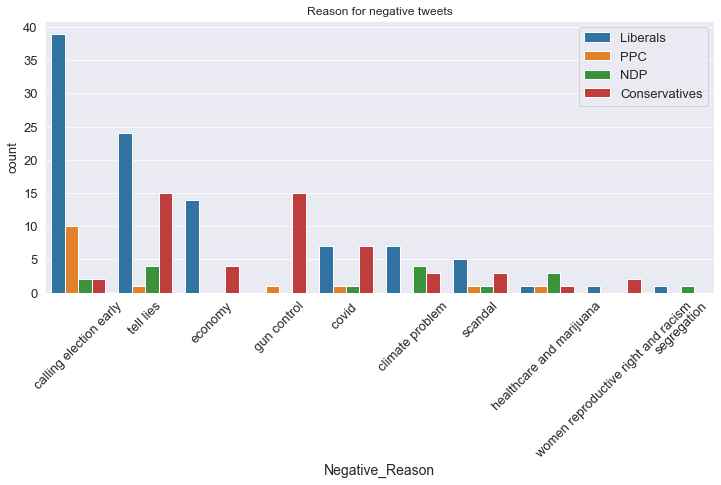

In [ ]:
cand_d_ned = cand_d.drop(cand_d.index[cand_d['negative_reason']=='others'])
plt.figure(figsize=(12,5))
sns.countplot(x='negative_reason',data = cand_d_ned,hue = 'party',order = cand_d_ned['negative_reason'].value_counts().index)
plt.xlabel('Negative_Reason',fontsize = 14)
plt.title('Reason for negative tweets',fontsize = 12)
plt.legend(loc='upper right')
plt.xticks(rotation=45)
plt.show()

From the plot it can be seen that liberals calling elections early account for the most number of negative tweets. The conservatives recieved most negative tweets for telling lies and gun control. It must be noted that the pandemic did not have any significant contribution in the negative tweets distribution. 

#  Sentiments dataset - Positive and Negative tweets 

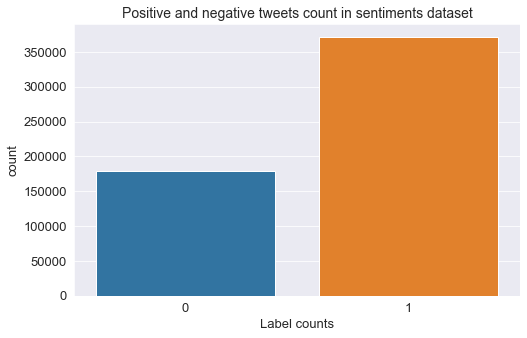

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(sentiments_df['label'])
plt.title('Positive and negative tweets count in sentiments dataset',fontsize = 14)
plt.xlabel('Label counts')
plt.show()

We can observe that the sentiments dataset has considerably higher positive tweets than negative

In [ ]:
#converting list to string for further analysis
sentiments_df['text'] = sentiments_df['text'].map(lambda x: ' '.join(map(str, x)))
canadian_election_df['text'] = canadian_election_df['text'].map(lambda x: ' '.join(map(str, x)))

# Sentiments dataset - Word Cloud (Positive tweets)

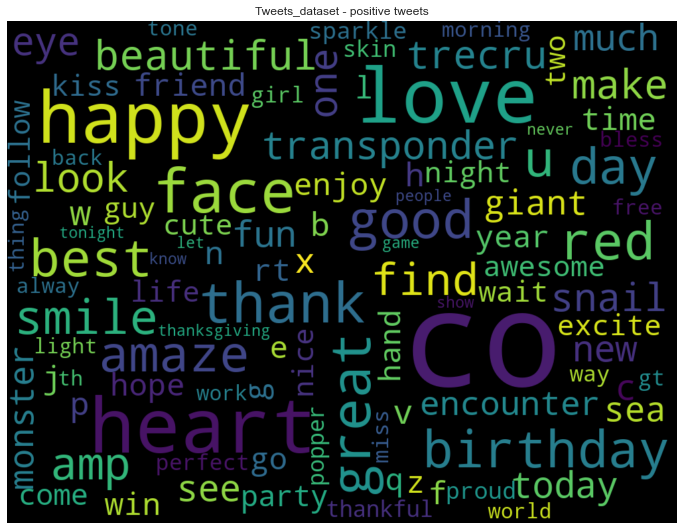

In [ ]:
df_post = sentiments_df[sentiments_df['label']==1]
df_post['text']=df_post['text'].map(lambda x: x+' ')
df_post_sent=df_post['text'].sum()

# Generate the wordcloud 
wordcloud = WordCloud(width=1000, height=750, max_words = 100, max_font_size=200, collocations=False,).generate(df_post_sent)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('Tweets_dataset - positive tweets',fontsize = 18)
plt.show()

# Word cloud - canadian elections (positive tweets)

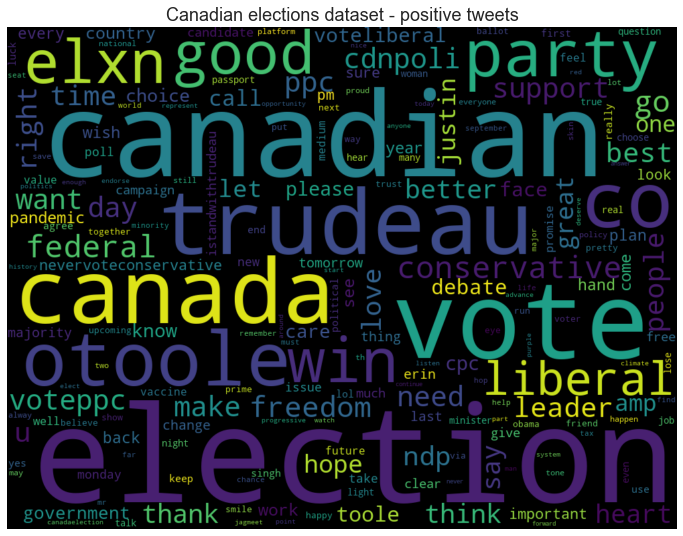

In [ ]:
df_post_can = canadian_election_df[canadian_election_df['sentiment']=='positive']
df_post_can['text']=df_post_can['text'].map(lambda x: x+' ')
df_post_sent_can=df_post_can['text'].sum()

# Generate the wordcloud 
wordcloud = WordCloud(width=1000, height=750, max_font_size=200, collocations=False,).generate(df_post_sent_can)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('Canadian elections dataset - positive tweets',fontsize = 18)
plt.show()

# Word cloud - Canadian elections (negative tweets)

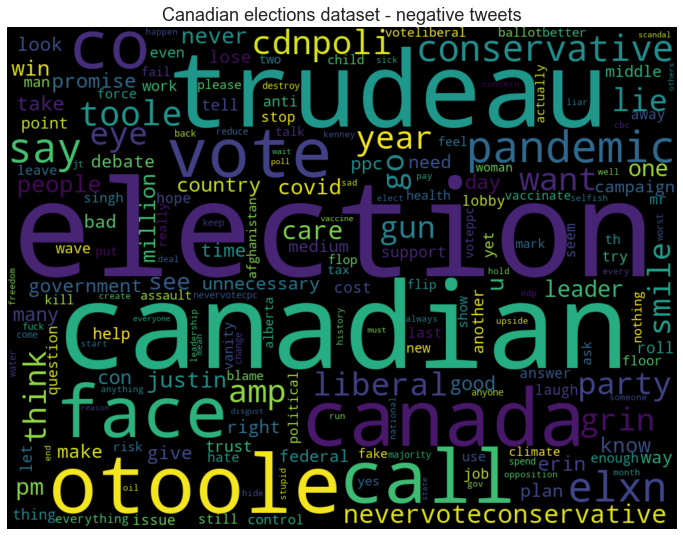

In [ ]:
df_n = canadian_election_df[canadian_election_df['sentiment']=='negative']
df_n['text']=df_n['text'].map(lambda x: x+' ')
df_n_sent=df_n['text'].sum()

# Generate the wordcloud 
wordcloud = WordCloud(width=1000, height=750, max_font_size=200, collocations=False,).generate(df_n_sent)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('Canadian elections dataset - negative tweets',fontsize = 18)
plt.show()

From the word cloud plots of positive and negative tweets for canadian elections dataset we can observe that the words 'election', ' canadian' , 'canada','vote','nevervoteconservative','otoole','trudeau' occured the most number of times.
While from the word cloud plot of positive tweets from sentiment dataset we can observe that the words 'happy','love','face','heart','thanks' have high frequency.

# 3. Model Preparation


In [ ]:
#splitting target variable and dependant feature
X = sentiments_df['text']
y = sentiments_df['label']

In [ ]:
#train-test split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)

In [ ]:
#Bag of words implementation
bagOfWords = CountVectorizer(max_features = 3000) 
X_train_b = bagOfWords.fit_transform(X_train)
X_test_b = bagOfWords.transform(X_test)

In [ ]:
#TfIdf implementation
TfIdf = TfidfVectorizer(max_features = 3000)
X_train_t = TfIdf.fit_transform(X_train)
X_test_t = TfIdf.transform(X_test)

# 4. Model Implementation
# 1.1 Logistic Regression - Bag of Words

In [ ]:
model = LogisticRegression()
acc_logreg = []
acc_logreg_train = []
model.fit(X_train_b,y_train)
y_pred = model.predict(X_test_b)
y_pred_train = model.predict(X_train_b)
acc_logreg_train.append(accuracy_score(y_train,y_pred_train))
acc_logreg.append(accuracy_score(y_test,y_pred))
print("Accuracy score on train data: {}%".format(accuracy_score(y_train,y_pred_train)*100))
print("Accuracy score for on test set logistic regression model using bag of words is: {}%".format(accuracy_score(y_test,y_pred)*100))


Accuracy score on train data: 96.1359866899575%
Accuracy score for on test set logistic regression model using bag of words is: 95.89566249591202%


# 1.2 Logistic Regression - TFIDF

In [ ]:
model = LogisticRegression()
acc_logreg_T = []
acc_logreg_train_T = []
model.fit(X_train_t,y_train)
y_pred = model.predict(X_test_t)
y_pred_train = model.predict(X_train_b)

acc_logreg_train_T.append(accuracy_score(y_train,y_pred_train))
acc_logreg_T.append(accuracy_score(y_test,y_pred))
print("Accuracy score on train data: {}%".format(accuracy_score(y_train,y_pred_train)*100))
print("Accuracy score for on test set logistic regression model using TFIDF is: {}%".format(accuracy_score(y_test,y_pred)*100))




Accuracy score on train data: 95.6007817833069%
Accuracy score for on test set logistic regression model using TFIDF is: 95.83388849186643%


# 2.1 Naive Bayes - Bag of Words

In [ ]:
gnb = BernoulliNB()
acc_nb = []
acc_nb_train = []
y_pred = gnb.fit(X_train_b, y_train).predict(X_test_b)
y_pred_train = gnb.predict(X_train_b)
acc_nb_train.append(accuracy_score(y_train,y_pred_train))
acc_nb.append(accuracy_score(y_test,y_pred))
print("Accuracy score on train data: {}%".format(accuracy_score(y_train,y_pred_train)*100))
print("Accuracy score on test set for Naive Bayes using bag of words is: {}%".format(accuracy_score(y_test,y_pred)*100))

Accuracy score on train data: 93.84332668004247%
Accuracy score on test set for Naive Bayes using bag of words is: 93.81472643806248%


# 2.2 Naive Bayes - TFIDF

In [ ]:
gnb = BernoulliNB()
acc_nb_t = []
acc_nb_train_t = []
y_pred = gnb.fit(X_train_t, y_train).predict(X_test_t)
y_pred_train = gnb.predict(X_train_b)
acc_nb_train_t.append(accuracy_score(y_train,y_pred_train))
acc_nb_t.append(accuracy_score(y_test,y_pred))
print("Accuracy score on train data: {}%".format(accuracy_score(y_train,y_pred_train)*100))
print("Accuracy score on test set for Naive Bayes using TFIDF is: {}%".format(accuracy_score(y_test,y_pred)*100))

Accuracy score on train data: 93.84332668004247%
Accuracy score on test set for Naive Bayes using TFIDF is: 93.81472643806248%


# 3.1 Random Forest - Bag of Words

In [ ]:
clf = RandomForestClassifier()
acc_rf = []
acc_rf_train = []
y_pred = clf.fit(X_train_b, y_train).predict(X_test_b)
y_pred_train = clf.predict(X_train_b)
acc_rf_train.append(accuracy_score(y_train,y_pred_train))
acc_rf.append(accuracy_score(y_test,y_pred))
print("Accuracy score on train data: {}%".format(accuracy_score(y_train,y_pred_train)*100))
print("Accuracy score on test set for random forest using bag of words is: {}%".format(accuracy_score(y_test,y_pred)*100))

Accuracy score on train data: 99.84608316700107%
Accuracy score on test set for random forest using bag of words is: 95.28337310287188%


# 3.2 Random Forest - TFIDF

In [ ]:
clf = RandomForestClassifier()
acc_rf_t = []
acc_rf_train_t = []
y_pred = clf.fit(X_train_t, y_train).predict(X_test_t)
y_pred_train = clf.predict(X_train_t)
acc_rf_train_t.append(accuracy_score(y_train,y_pred_train))
acc_rf_t.append(accuracy_score(y_test,y_pred))
print("Accuracy score on train data: {}%".format(accuracy_score(y_train,y_pred_train)*100))
print("Accuracy score on test set for random forest using TFIDF is: {}%".format(accuracy_score(y_test,y_pred)*100))

Accuracy score on train data: 99.84400671731474%
Accuracy score on test set for random forest using TFIDF is: 95.34999212684262%


# 4.1 Knn - Bag of Words

In [ ]:
%%time
neigh = KNeighborsClassifier()
acc_knn = []
acc_knn_train = []
neigh.fit(X_train_b,y_train)
y_pred_train = neigh.predict(X_train_b)
y_pred = neigh.predict(X_test_b)
acc_knn_train.append(accuracy_score(y_train,y_pred_train))
acc_knn.append(accuracy_score(y_test,y_pred))
print("Accuracy score on train data: {}%".format(accuracy_score(y_train,y_pred_train)*100))
print("Accuracy score on test set for KNN using bag of words is: {}%".format(accuracy_score(y_test,y_pred)*100))

Accuracy score on train data: 92.501%
Accuracy score on test set for KNN using bag of words is: 88.9200450586853%
CPU times: user 7min 16s, sys: 3min 52s, total: 11min 9s
Wall time: 11min 55s


# 4.2 Knn - TFIDF

In [ ]:
%%time
neigh = KNeighborsClassifier()
acc_knn_t = []
acc_knn_train_t = []
neigh.fit(X_train_t,y_train)
y_pred_train = neigh.predict(X_train_t)
y_pred = neigh.predict(X_test_t)
acc_knn_train_t.append(accuracy_score(y_train,y_pred_train))
acc_knn_t.append(accuracy_score(y_test,y_pred))
print("Accuracy score on train data for TFIDF: {}%".format(accuracy_score(y_train[:100000],y_pred_train)*100))
print("Accuracy score on test set for KNN TFIDF is: {}%".format(accuracy_score(y_test,y_pred)*100))

Accuracy score on train data for TFIDF: 90.086%
Accuracy score on test set for KNN TFIDF is: 85.0488741384949%
CPU times: user 8min 1s, sys: 3min 59s, total: 12min 1s
Wall time: 13min 1s


# 5.1 XG-Boost (BOW)

In [ ]:
clf = GradientBoostingClassifier()
acc_xg = []
acc_xg_train = []
y_pred = clf.fit(X_train_b, y_train).predict(X_test_b)
y_pred_train = clf.predict(X_train_b)
acc_xg_train.append(accuracy_score(y_train,y_pred_train))
acc_xg.append(accuracy_score(y_test,y_pred))
print("Accuracy score on train data: {}%".format(accuracy_score(y_train,y_pred_train)*100))
print("Accuracy score on test set for XGBoost using bag of words is: {}%".format(accuracy_score(y_test,y_pred)*100))


Accuracy score on train data: 87.40737087727403%
Accuracy score on test set for XGBoost using bag of words is: 87.19097857289938%


# 5.2 XG-Boost (TFIDF)

In [ ]:
clf = GradientBoostingClassifier()
acc_xg_t = []
acc_xg_train_t = []
y_pred = clf.fit(X_train_t, y_train).predict(X_test_t)
y_pred_train = clf.predict(X_train_t)
acc_xg_train_t.append(accuracy_score(y_train,y_pred_train))
acc_xg_t.append(accuracy_score(y_test,y_pred))
print("Accuracy score on train data: {}%".format(accuracy_score(y_train,y_pred_train)*100))
print("Accuracy score on test set for XGBoost using TFIDF is: {}%".format(accuracy_score(y_test,y_pred)*100))

Accuracy score on train data: 79.34737186358764%
Accuracy score on test set for XGBoost using TFIDF is: 79.4674111847285%


# 6.1 SVM - Bag of Words

In [ ]:
clf = LinearSVC()
acc_svm = []
acc_svm_train = []
y_pred = clf.fit(X_train_b, y_train).predict(X_test_b)
y_pred_train = clf.predict(X_train_b)
acc_svm_train.append(accuracy_score(y_train,y_pred_train))
acc_svm.append(accuracy_score(y_test,y_pred))
print("Accuracy score on train data: {}%".format(accuracy_score(y_train,y_pred_train)*100))
print("Accuracy score on test set for SVM using bag of words is: {}%".format(accuracy_score(y_test,y_pred)*100))


Accuracy score on train data: 96.07940343600512%
Accuracy score on test set for SVM using bag of words is: 95.83812788430093%


# 6.2 SVM - TFIDF

In [ ]:
clf = LinearSVC()
acc_svm_t = []
acc_svm_train_t = []
y_pred = clf.fit(X_train_t, y_train).predict(X_test_t)
y_pred_train = clf.predict(X_train_t)
acc_svm_train_t.append(accuracy_score(y_train,y_pred_train))
acc_svm_t.append(accuracy_score(y_test,y_pred))
print("Accuracy score on train data: {}%".format(accuracy_score(y_train,y_pred_train)*100))
print("Accuracy score on test set for SVM using Tfidf is: {}%".format(accuracy_score(y_test,y_pred)*100))


Accuracy score on train data: 96.11366485582951%
Accuracy score on test set for SVM using Tfidf is: 95.84297290422606%


# 7.1 Decision Tree - BOW

In [ ]:
clf = DecisionTreeClassifier(random_state=0)
acc_dt = []
acc_dt_train = []
y_pred = clf.fit(X_train_b, y_train).predict(X_test_b)
y_pred_train = clf.predict(X_train_b)
acc_dt_train.append(accuracy_score(y_train,y_pred_train))
acc_dt.append(accuracy_score(y_test,y_pred))
print("Accuracy score on train data: {}%".format(accuracy_score(y_train,y_pred_train)*100))
print("Accuracy score on test set for decision tree using bag of words is: {}%".format(accuracy_score(y_test,y_pred)*100))



NameError: ignored

# 7.2 Decision Tree - TFIDF

In [ ]:
clf = DecisionTreeClassifier(random_state=0)
acc_dt_t = []
acc_dt_train_t = []
y_pred = clf.fit(X_train_t, y_train).predict(X_test_t)
y_pred_train = clf.predict(X_train_t)
acc_dt_train_t.append(accuracy_score(y_train,y_pred_train))
acc_dt_t.append(accuracy_score(y_test,y_pred))
print("Accuracy score on train data: {}%".format(accuracy_score(y_train,y_pred_train)*100))
print("Accuracy score on test set for decision tree using Tfidf is: {}%".format(accuracy_score(y_test,y_pred)*100))


Accuracy score on train data: 99.84608316700107%
Accuracy score on test set for decision tree using Tfidf is: 93.59185552150583%


# Model perfromance

In [ ]:
ind = ['Logistic_Reg','Navie_Bayes','KNN','SVM','Decision_Tree','Random_Forest','Xg_boost']
scores_Bag = [acc_logreg,acc_nb,acc_knn,acc_svm,acc_dt,acc_rf,acc_xg]
scores_tfidf = [acc_logreg_T,acc_nb_t,acc_knn_t,acc_svm_t,acc_dt_t,acc_rf_t,acc_xg_t]
models_df = pd.DataFrame()
for i,j in zip(scores_Bag,scores_tfidf):
    df_2 = pd.DataFrame()
    df_2['Bag_of_words'] = i
    df_2['TF-Idf'] = j
    models_df = models_df.append(df_2)
models_df.insert(0,'Models',ind)
models_df.set_index('Models',inplace=True)

models_df=models_df.multiply(100)
models_df

,Bag_of_words,TF-Idf
Models,,
Logistic_Reg,95.895662,95.833888
Navie_Bayes,93.814726,93.814726
KNN,88.920045,85.048874
SVM,95.838128,95.842973
Decision_Tree,93.367168,93.591856
Random_Forest,95.283373,95.349992
Xg_boost,87.190979,79.467411


<Figure size 432x288 with 0 Axes>

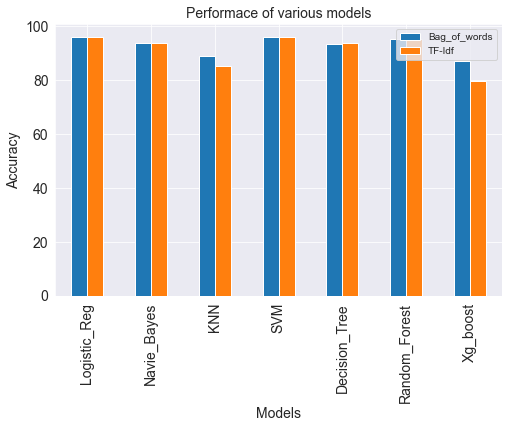

In [ ]:
plt.figure()
models_df.plot(kind = 'bar',figsize=(8,5),fontsize=14)
plt.xlabel('Models',fontsize = 14)
plt.ylabel('Accuracy',fontsize = 14)
plt.title('Performace of various models',fontsize = 14)
plt.show()

After training our dataset on the above models, we oberved that the logistic regression model (bag of words) had the best accuracy on the test set (close to 96%). However, a very marginal difference was observed in terms of the model accuracy on test set between Naive Bayes, SVM, Random Forest and Decision tree algorithms. The model had least accuracy when trained with KNN. The XG boost model had high accuracy with bag of words features but accuracy dropped when we used the TFIDF features with for the XG boost model.
Thus, we conclude that the logistic regression model with bag of words features is our best model with about 95.89 % accuracy.

# 4.a.a) prediction on elections data

# Data Preparation

In [ ]:
# Encoding the negative and positive sentiments as 0 and 1 respectively and adding another column as y_true for further analysis
X_elections = canadian_election_df['text']
y_true = []
for x in canadian_election_df['sentiment']:
    if x == 'negative':
        y_true.append(0)
    else:
        y_true.append(1)
canadian_election_df['sentiment_encoded'] = y_true

In [ ]:
#Using bag of words features for elections dataset
X_ele_b = bagOfWords.transform(X_elections)

# Implementation - Bag of Words

Accuracy score on elections dataset: 70.05988023952095%
F1 score on elections dataset 0.708171206225681


Text(0.5, 1.0, 'Logistic regression performance on elections dataset')

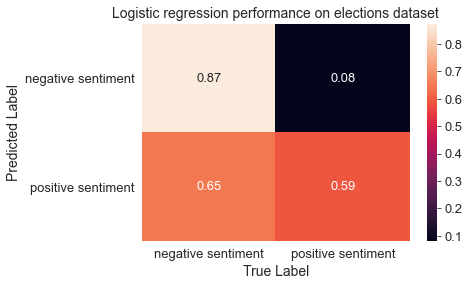

In [ ]:
model = LogisticRegression()
acc_logreg_e_b = []
model.fit(X_train_b,y_train)
y_pred_b = model.predict(X_ele_b)
acc_logreg_e_b.append(accuracy_score(y_true,y_pred_b))
print("Accuracy score on elections dataset: {}%".format(accuracy_score(y_true,y_pred_b)*100))
print("F1 score on elections dataset {}".format(f1_score(y_true,y_pred_b)))

#confusion_matrix
cm = confusion_matrix(y_true, y_pred_b)
cm = (cm / cm.astype(np.float).sum(axis=1))
class_names = ['negative sentiment','positive sentiment']
sns.heatmap(cm, annot=True, xticklabels=class_names, yticklabels=class_names)
plt.xlabel("True Label",fontsize = 14) 
plt.ylabel("Predicted Label",fontsize = 14)
plt.title("Logistic regression performance on elections dataset",fontsize = 14)

In [ ]:
print(classification_report(y_true, y_pred_b))

              precision    recall  f1-score   support

           0       0.57      0.87      0.69       387
           1       0.88      0.59      0.71       615

    accuracy                           0.70      1002
   macro avg       0.73      0.73      0.70      1002
weighted avg       0.76      0.70      0.70      1002



# 4.a.b) Discussion:

The accuracy of our model on the canadian elections tweets dataset is about 70.82 percent while the F1-score is 0.7.
The accuracy of our model dropped to 70 percent on the generic tweets dataset. It could be because of the smaller size of the dataset and the difference nature of the tweets in both the datasets in that the canadian election dataset has tweets specific to the 2021 elections while the tweets in the sentiments dataset are more generic in nature.

We use F1 score and confusion matrix to evaluate the performance of our model.
We use F1 Score because it takes both precision and recall into account thus helps us avoid the precision-recall tradeoff. It also takes into account the distribution of data.
As seen in the EDA step, there are unequal number of positive and negative labels in our dataset hence in this case, intrepreting performance through accuracy can be misleading. Confusion matrix summarizes the results and also tells us what our model is predicting correctly and the errors that it is making. For our model, the confusion matrix shows that it is predicting the False Negatives incorrectly.
Also, the classification report shows that the model was able to predict the negative tweets with 0.57 precision and the positive with 0.88 precision. 


# Part 4.a.c : Visualize prediction result and true sentiment label for all four parties

In [ ]:
# Data preparation to visualize all four parties 
canadian_election_df['predictions'] = y_pred_b
liberals = canadian_election_df[canadian_election_df['party']=='Liberals']
ndp = canadian_election_df[canadian_election_df['party']=='NDP']
ppc = canadian_election_df[canadian_election_df['party']=='PPC']
conservative = canadian_election_df[canadian_election_df['party']=='Conservatives']

# confusion matrix for all four parties

              precision    recall  f1-score   support

           0       0.63      0.89      0.74       145
           1       0.82      0.50      0.62       150

    accuracy                           0.69       295
   macro avg       0.73      0.69      0.68       295
weighted avg       0.73      0.69      0.68       295



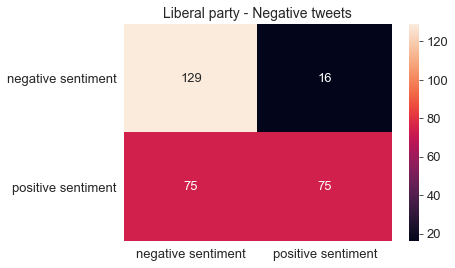

In [ ]:
#plot for confusion matrix
print(classification_report(liberals['sentiment_encoded'],liberals['predictions']))

cm_lib = confusion_matrix(liberals['sentiment_encoded'],liberals['predictions'])
class_names = ['negative sentiment','positive sentiment']
plt.xlabel("True Label") 
plt.ylabel("Predicted Label")
plt.title("Liberal party - Negative tweets",fontsize = 14)
sns.heatmap(cm_lib,annot=True,fmt='d',xticklabels = class_names, yticklabels = class_names)
plt.show()

              precision    recall  f1-score   support

           0       0.57      0.83      0.68        96
           1       0.85      0.60      0.71       154

    accuracy                           0.69       250
   macro avg       0.71      0.72      0.69       250
weighted avg       0.74      0.69      0.69       250



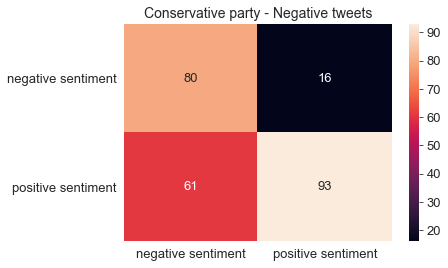

In [ ]:
print(classification_report(conservative['sentiment_encoded'],conservative['predictions']))
cm_con = confusion_matrix(conservative['sentiment_encoded'],conservative['predictions'])
class_names = ['negative sentiment','positive sentiment']
plt.xlabel("True Label") 
plt.ylabel("Predicted Label")
plt.title("Conservative party - Negative tweets",fontsize = 14)
sns.heatmap(cm_con,annot=True,fmt='d',xticklabels = class_names, yticklabels = class_names)
plt.show()


              precision    recall  f1-score   support

           0       0.47      0.88      0.61        25
           1       0.93      0.63      0.75        68

    accuracy                           0.70        93
   macro avg       0.70      0.76      0.68        93
weighted avg       0.81      0.70      0.72        93



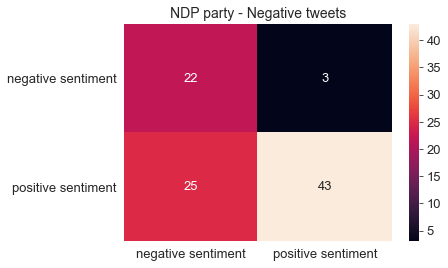

In [ ]:
print(classification_report(ndp['sentiment_encoded'],ndp['predictions']))
cm_ndp = confusion_matrix(ndp['sentiment_encoded'],ndp['predictions'])
class_names = ['negative sentiment','positive sentiment']
plt.xlabel("True Label") 
plt.ylabel("Predicted Label")
plt.title("NDP party - Negative tweets",fontsize = 14)
sns.heatmap(cm_ndp,annot=True,fmt='d',xticklabels = class_names, yticklabels = class_names)
plt.show()
plt.show()

              precision    recall  f1-score   support

           0       0.47      0.82      0.60        17
           1       0.86      0.53      0.65        34

    accuracy                           0.63        51
   macro avg       0.66      0.68      0.63        51
weighted avg       0.73      0.63      0.63        51



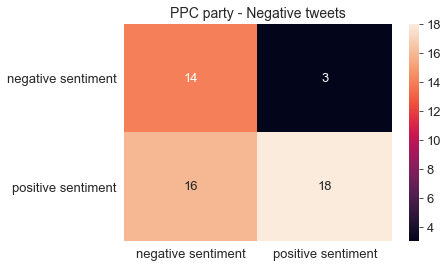

In [ ]:
print(classification_report(ppc['sentiment_encoded'],ppc['predictions']))


cm_ppc = confusion_matrix(ppc['sentiment_encoded'],ppc['predictions'])
class_names = ['negative sentiment','positive sentiment']
plt.xlabel("True Label") 
plt.ylabel("Predicted Label")
plt.title("PPC party - Negative tweets",fontsize = 14)
sns.heatmap(cm_ppc,annot=True,fmt='d',xticklabels = class_names, yticklabels = class_names)
plt.show()

# plot for true and predicted labels for all four parties

In [ ]:
#preparing dataset for plotting actual and predicted values
mapper = {0:'negative',1:'positive'}
liberals['predictions_en'] = liberals['predictions'].map(mapper)
conservative['predictions_en'] = conservative['predictions'].map(mapper)
ndp['predictions_en'] = ndp['predictions'].map(mapper)
ppc['predictions_en'] = ppc['predictions'].map(mapper)

Text(0.5, 1.0, 'PPC - Actual vs Predicted')

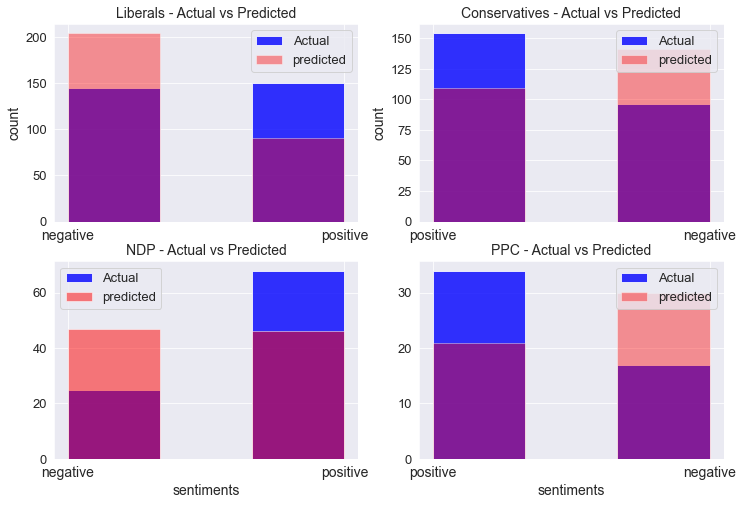

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(12,8))

ax[0,0].hist(liberals['sentiment'],bins = 3,color='b',alpha=0.8,label="Actual")
ax[0,0].hist(liberals['predictions_en'],bins =3,color='r',alpha=0.4,label="predicted")
ax[0,0].tick_params(axis="x", labelsize=14) 
#ax[0,0].set_xlabel("sentiments",fontsize=14)
ax[0,0].set_ylabel("count",fontsize=14)
ax[0,0].legend()
#ax.set_xticklabels(ax.get_xticklabels(), rotation = 30, size = 10)
ax[0,0].set_title("Liberals - Actual vs Predicted",fontsize = 14)

ax[0,1].hist(conservative['sentiment'],bins = 3,color='b',alpha=0.8,label="Actual")
ax[0,1].hist(conservative['predictions_en'],bins =3,color='r',alpha=0.4,label="predicted")
ax[0,1].tick_params(axis="x", labelsize=14) 
#ax[0,1].set_xlabel("sentiments",fontsize=14)
ax[0,1].set_ylabel("count",fontsize=14)
ax[0,1].legend()
#ax.set_xticklabels(ax.get_xticklabels(), rotation = 30, size = 10)
ax[0,1].set_title("Conservatives - Actual vs Predicted",fontsize = 14)


ax[1,0].hist(ndp['sentiment'],bins = 3,color='b',alpha=0.8,label="Actual")
ax[1,0].hist(ndp['predictions_en'],bins =3,color='r',alpha=0.5,label="predicted")
ax[1,0].tick_params(axis="x", labelsize=14) 
ax[1,0].set_xlabel("sentiments",fontsize=14)
ax[1,0].legend()
#ax[1,0].set_ylabel("count",fontsize=14)
#ax.set_xticklabels(ax.get_xticklabels(), rotation = 30, size = 10)
ax[1,0].set_title("NDP - Actual vs Predicted",fontsize = 14)

ax[1,1].hist(ppc['sentiment'],bins = 3,color='b',alpha=0.8,label="Actual")
ax[1,1].hist(ppc['predictions_en'],bins =3,color='r',alpha=0.4,label="predicted")
ax[1,1].tick_params(axis="x", labelsize=14) 
ax[1,1].set_xlabel("sentiments",fontsize=14)
#ax[1,1].set_ylabel("count",fontsize=14)
ax[1,1].legend()
#ax.set_xticklabels(ax.get_xticklabels(), rotation = 30, size = 10)
ax[1,1].set_title("PPC - Actual vs Predicted",fontsize = 14)
#plt.tight_layout()
#for a in ax.flat:
 #   a.label_outer()


# Discussion:

In my opininon, performing NLP on tweets can prove helpful to the political parties as it can help them understand the public sentiments, what are the pain points of the masses and what are the things/policies that they are happy with. The political parties can formulate their election manifesto accordingly and talk about their vision to resolve the issues that the citizens are facing. The analysis thus would give an insight about how the party is being viewed in public eye. However, the political parties cannot rely on this model to predict the election results.

Liberals:
The cofusion matrix for the liberals party show that our model predicts false negatives incorrectly. These labels are actually positive but are predicted as negative by our model. The plot for actual and predicted labels shows that the model overestimates the negative labels and underestimates the postive tweets. It must be noted that the distribution of actual positive and negative tweets is almost the same which means that the liberal party has as many people opposing it as the number of people in its support.

Conservatives:
The cofusion matrix for the conservatives party show that our model predicts false negatives incorrectly. These labels are actually positive but are predicted as negative by our model. Our model underestimates the positive tweets and overestimates the positive ones. Also, there is a considerable amount of difference between the actual positive and negative tweets for the conservative party. The positive tweets count for conservatives is almost the same as liberals if not more and the number of negative tweets is quite less as compared to the liberals. We know that the leader of the liberals party prime misinter Justin Trudeau called for early elections so that the liberals could attain absolute majority in the house, the data indicates that there are still many voters who are in the favour of the conservatives which is the opposition party.

NDP:
The cofusion matrix for the NDP party show that our model predicts false negatives incorrectly. These labels are actually positive but are predicted as negative by our model. Our model underestimates the positive tweets for the NDP party and overestimates the negative tweets. The actual labels show that the NDP has a lot of positive tweets as compared to negative ones.

PPC:
The cofusion matrix for the PPC party show that our model predicts false negatives incorrectly. These labels are actually positive but are predicted as negative by our model. Our model underestimates the positive tweets for the NDP party and overestimates the negative tweets. The actual labels show that the PPC has a lot of positive tweets as compared to negative ones.


To conclude, the basic trend that can be seen through our analysis is that our model is overestimating the amount of negative tweets for each party and underestimating the positive tweets. Also the plots for confusion matrix indicate that the model has incorrect false negatives predictions. For liberals and PPC the number of TP and FP was almost the same. Also the accuracy for all four parties as per the classification report was close to 70%.


# Part 4.b : Negative Reason Analysis

In [ ]:
#considering only negative tweets
negative_df = canadian_election_df[canadian_election_df['sentiment']=='negative']

In [ ]:
negative_df['negative_reason'].value_counts()

others                                 149
calling election early                  73
tell lies                               61
covid                                   25
economy                                 20
gun control                             16
climate problem                         15
scandal                                 14
healthcare and marijuana                 7
women reproductive right and racism      4
segregation                              3
Name: negative_reason, dtype: int64

In [ ]:
#label encoding the negative reasons
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
negative_df['negative_reason_Cat'] = labelencoder.fit_transform(negative_df['negative_reason'])
negative_df.head()

,text,sentiment,negative_reason,party,sentiment_encoded,predictions,negative_reason_Cat
0,canadian election power grab pm trudeau yes ta...,negative,calling election early,Liberals,0,1,0
1,hope trudeau lose canadian election tomorrow c...,negative,covid,Liberals,0,0,2
3,canadian friend never forget trudeau year mand...,negative,calling election early,Liberals,0,0,0
5,vaccine amp gun key election toole serious pla...,negative,covid,None,0,0,2
6,sorry moderator respond leadership candidate d...,negative,others,None,0,0,6


# Data preparation

In [ ]:
X = negative_df['text']
y = negative_df['negative_reason_Cat']
x_train, x_test, Y_train, Y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)

In [ ]:
bagOfWords = CountVectorizer(max_features = 3000) 
x_train_bag = bagOfWords.fit_transform(x_train)
x_test_bag = bagOfWords.transform(x_test)

In [ ]:
# Hyperparameter tuning
parameters = {'C':[0.01, 0.1, 1, 10], 'solver':('liblinear','lbfgs', 'newton-cg')}

clf_lr = LogisticRegression()
clf = GridSearchCV(clf_lr, parameters, cv=5, n_jobs=-1)
clf.fit(x_train_bag, Y_train)

print('The best cross-validation score: {}%'.format(round(clf.best_score_*100,2)))
print('The best parameter:\n', clf.best_params_)

The best cross-validation score: 48.89%
The best parameter:
 {'C': 1, 'solver': 'liblinear'}


Accuracy score for negative reasons: 41.88034188034188%
F1 score for negative reasons: 0.3602353579847953
              precision    recall  f1-score   support

           0       0.39      0.73      0.51        15
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         7
           3       0.00      0.00      0.00         9
           4       0.75      0.60      0.67         5
           5       0.00      0.00      0.00         2
           6       0.51      0.63      0.56        52
           7       0.00      0.00      0.00         5
           9       0.12      0.14      0.13        14
          10       0.00      0.00      0.00         2

    accuracy                           0.42       117
   macro avg       0.18      0.21      0.19       117
weighted avg       0.32      0.42      0.36       117



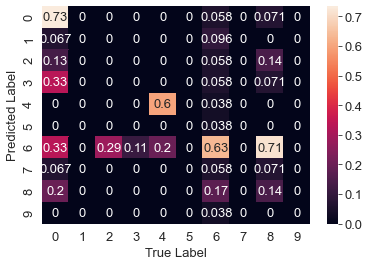

In [ ]:
model = LogisticRegression(C = 1, solver = 'liblinear')
acc_logreg_bag = []
acc_logreg_train_bag = []
model.fit(x_train_bag,Y_train)
y_pred = model.predict(x_test_bag)
print("Accuracy score for negative reasons: {}%".format(accuracy_score(Y_test,y_pred)*100))
print("F1 score for negative reasons: {}".format(f1_score(Y_test,y_pred,average='weighted')))
acc_logreg_bag.append(accuracy_score(Y_test,y_pred))
cm = confusion_matrix(Y_test, y_pred)
cm = (cm / cm.astype(np.float).sum(axis=1))
sns.heatmap(cm, annot=True)
plt.xlabel("True Label") 
plt.ylabel("Predicted Label")

print(classification_report(Y_test, y_pred))

# Testing the same model after combining similar reasons in to fewer categories

In [ ]:
#considering only negative tweets
negative_df = canadian_election_df[canadian_election_df['sentiment']=='negative']

In [ ]:
negative_df.head()

,text,sentiment,negative_reason,party,sentiment_encoded,predictions
0,canadian election power grab pm trudeau yes ta...,negative,calling election early,Liberals,0,1
1,hope trudeau lose canadian election tomorrow c...,negative,covid,Liberals,0,0
3,canadian friend never forget trudeau year mand...,negative,calling election early,Liberals,0,0
5,vaccine amp gun key election toole serious pla...,negative,covid,None,0,0
6,sorry moderator respond leadership candidate d...,negative,others,None,0,0


In [ ]:
negative_df['negative_reason'].unique()

array(['calling election early', 'covid ', 'others', 'scandal',
       'tell lies', 'gun control', 'economy', 'healthcare and marijuana',
       'segregation', 'women reproductive right and racism',
       'climate problem'], dtype=object)

In [ ]:
negative_df['negative_reason'].value_counts()

others                                 149
calling election early                  73
tell lies                               61
covid                                   25
economy                                 20
gun control                             16
climate problem                         15
scandal                                 14
healthcare and marijuana                 7
women reproductive right and racism      4
segregation                              3
Name: negative_reason, dtype: int64

In [ ]:
personal = ['segregation','scandal']
social = ['women reproductive right and racism','healthcare and marijuana','climate problem','gun control']
for i in personal:
    negative_df['negative_reason'].replace(i,'personal',inplace = True)
for i in social:
     negative_df['negative_reason'].replace(i,'social',inplace = True)

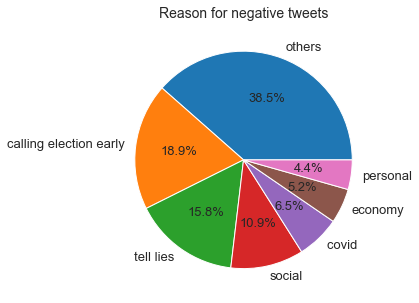

In [ ]:
plt.figure(figsize=(8,5))
negative_df['negative_reason'].value_counts().plot.pie(fontsize = 13,autopct='%1.1f%%')
plt.axis('off')
plt.title('Reason for negative tweets',fontsize = 14)
plt.show()

Since the number of negative reasons for :'women reproductive right and racism','healthcare and marijuana','climate problem ','gun control', 'segregation ','scandal' is less and are related to one another, we group them in to 'personal' and 'social' labels for further analysis.


In [ ]:
#combining similar labels 
negative_df['negative_reason'].replace(['calling election early','tell lies','personal',
                                      'economy','social','covid ','others'],
                                      [0,1,2,3,4,5,6],inplace=True)

In [ ]:
negative_df.head()

,text,sentiment,negative_reason,party,sentiment_encoded,predictions
0,canadian election power grab pm trudeau yes ta...,negative,0,Liberals,0,1
1,hope trudeau lose canadian election tomorrow c...,negative,5,Liberals,0,0
3,canadian friend never forget trudeau year mand...,negative,0,Liberals,0,0
5,vaccine amp gun key election toole serious pla...,negative,5,None,0,0
6,sorry moderator respond leadership candidate d...,negative,6,None,0,0


In [ ]:
#seperate target and feature variables
X = negative_df['text']
y = negative_df['negative_reason']
x_train, x_test, Y_train, Y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)

In [ ]:
bagOfWords = CountVectorizer(max_features = 3000) 
x_train_bag = bagOfWords.fit_transform(x_train)
x_test_bag = bagOfWords.transform(x_test)

# Hyperparameter tuning 

In [ ]:
parameters = {'C':[0.01, 0.1, 1, 10], 'solver':('liblinear','lbfgs', 'newton-cg')}

clf_lr = LogisticRegression()
clf = GridSearchCV(clf_lr, parameters, cv=5, n_jobs=-1)
clf.fit(x_train_bag, Y_train)

print('The best cross-validation score: {}%'.format(round(clf.best_score_*100,2)))
print('The best parameter:\n', clf.best_params_)

The best cross-validation score: 50.37%
The best parameter:
 {'C': 0.1, 'solver': 'liblinear'}


Accuracy score for negative reasons: 47.863247863247864%
F1 score for negative reasons: 0.39251928115391116
              precision    recall  f1-score   support

           0       0.42      0.87      0.57        15
           1       0.12      0.07      0.09        14
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         9
           4       0.50      0.13      0.21        15
           5       0.00      0.00      0.00         7
           6       0.54      0.77      0.63        52

    accuracy                           0.48       117
   macro avg       0.23      0.26      0.21       117
weighted avg       0.37      0.48      0.39       117



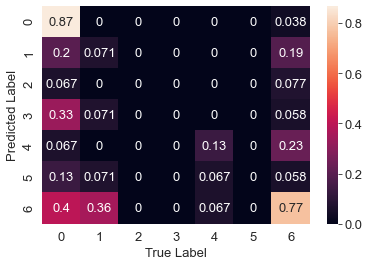

In [ ]:
model = LogisticRegression(C = 0.1, solver = 'liblinear')
acc_logreg_bag = []
acc_logreg_train_bag = []
model.fit(x_train_bag,Y_train)
y_pred = model.predict(x_test_bag)
print("Accuracy score for negative reasons: {}%".format(accuracy_score(Y_test,y_pred)*100))
print("F1 score for negative reasons: {}".format(f1_score(Y_test,y_pred,average='weighted')))
acc_logreg_bag.append(accuracy_score(Y_test,y_pred))
cm = confusion_matrix(Y_test, y_pred)
cm = (cm / cm.astype(np.float).sum(axis=1))
sns.heatmap(cm, annot=True)
plt.xlabel("True Label") 
plt.ylabel("Predicted Label")

print(classification_report(Y_test, y_pred))


# Discussion:

The accuracy of our model increased slightly from 41% to around 48% after combining the similar labels in our model. However there was almost no difference in the f1 score for the first model was around 0.37 and for the second model was around 0.39.
The reason for the poor performance of our model could be insufficient amount of data or difference in the distribution of the data in terms of the training and testing datasets.
To improve the performance of our model we can consider performing some feature engineering techniques and use a dataset that is more relevant to the 2021 canadian elections and one that also contains more data. We can also include more keywords when classifying the political parties and exclude words that are not relevant to our analysis from our dataset.

# 4c

# Top 50 most repeated positive words

In [ ]:
#splitting positive and negative tweets
positive = canadian_election_df[canadian_election_df['sentiment']=='positive']
negative = canadian_election_df[canadian_election_df['sentiment']=='negative']

In [ ]:

freq_vect = CountVectorizer(max_features=1000)
positive_corpus = freq_vect.fit_transform(positive['text'])
positive_corpus = positive_corpus.toarray()

In [ ]:
positive_vocab = freq_vect.get_feature_names()
df_positive= pd.DataFrame(data=positive_corpus,columns=positive_vocab)
df_positive_ = df_positive.sum(axis=0).sort_values(ascending=False)[:50]

In [ ]:
# List of positive keywords
df_positive_

election        428
canadian        319
vote            269
trudeau         178
canada          177
co              130
otoole          124
party            90
get              87
win              80
elxn             75
good             74
liberal          62
conservative     60
federal          59
go               57
like             55
freedom          53
cdnpoli          50
day              50
support          49
need             48
ppc              48
want             47
voteppc          47
make             47
leader           45
right            44
best             44
time             43
people           43
love             40
ndp              40
better           38
thank            38
would            38
think            38
heart            37
say              37
great            36
hope             36
justin           35
let              35
amp              34
one              33
call             32
toole            31
debate           30
face             29
voteliberal      29


# Top 50 most repeated negative words

In [ ]:
negative_corpus = freq_vect.fit_transform(negative['text'])
negative_corpus = negative_corpus.toarray()
negative_vocab = freq_vect.get_feature_names()
df_negative= pd.DataFrame(data=negative_corpus,columns=negative_vocab)
df_negative_ = df_negative.sum(axis=0).sort_values(ascending=False)[:50]

In [ ]:
#List of negative tweets
df_negative_

election                 272
canadian                 211
trudeau                  159
otoole                    88
canada                    84
call                      72
face                      67
vote                      63
co                        60
pandemic                  51
elxn                      46
like                      45
say                       44
conservative              42
get                       40
toole                     37
cdnpoli                   36
eye                       35
amp                       35
want                      35
liberal                   33
year                      33
grin                      32
go                        32
party                     32
lie                       32
smile                     31
think                     31
gun                       31
care                      30
nevervoteconservative     30
pm                        26
people                    26
see                       26
leader        

<AxesSubplot:xlabel='words', ylabel='count'>

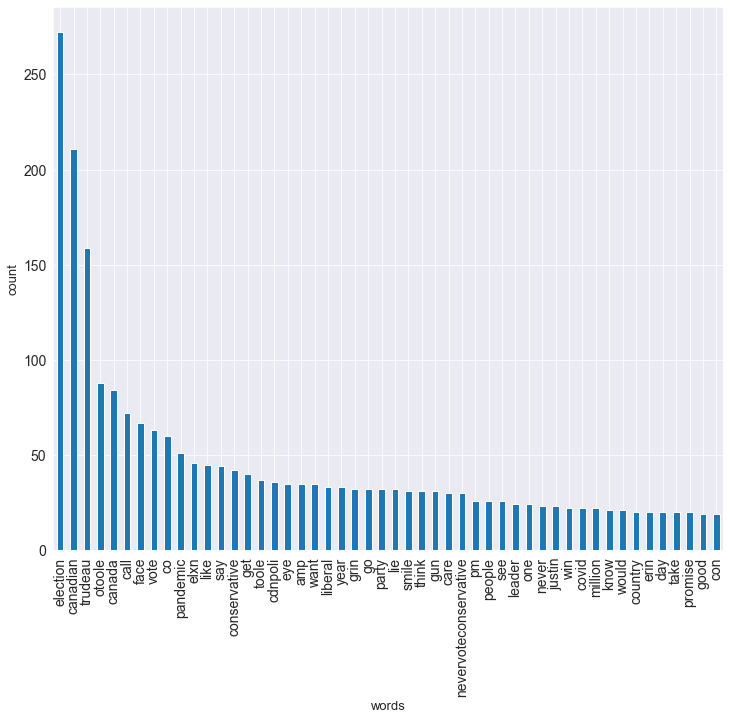

In [ ]:
#plot for negative tweets
df_negative_.plot(kind = 'bar',figsize = (12,10),fontsize= 14,xlabel = 'words',ylabel = 'count')